In [1]:
import os
import time
import glob

import pandas as pd
import polars as pl
import numpy as np
import xgboost as xgb
import cudf
from sklearn.model_selection import GroupKFold
import joblib
from matplotlib import pyplot as plt

In [2]:
DATASET_PATH = "/home/search2/lichunyu/otto-recommender-system/data/input"

TYPE_MAP = {'clicks':0, 'carts':1, 'orders':2}

def read_parquet(f):
    df = pd.read_parquet(f)
    df.ts = (df.ts/1000).astype('int32')
    df['type'] = df['type'].map(TYPE_MAP).astype('int8')
    return df

In [3]:
train_files: list = sorted(glob.glob(os.path.join(DATASET_PATH, "otto-validation/train_parquet/*.parquet")))
# train_files

In [4]:
test_files: list = sorted(glob.glob(os.path.join(DATASET_PATH, "otto-validation/test_parquet/*.parquet")))
# test_files

In [ ]:
%%time
df_train = read_parquet(train_files[0])
df_train = df_train[df_train["session"].isin(pd.DataFrame(np.random.choice(df_train.session.unique(), int(TRAIN_SESSION_SAMPLE_SIZE))).rename({0: "session"}, axis=1)["session"])]
train_ts_maximal = df_train["ts"].max()
train_ts_minimal = df_train["ts"].min()
df_train_label = df_train[(train_ts_maximal-df_train["ts"]) < 24*60*60].reset_index(drop=True)
df_train = df_train[(train_ts_maximal-df_train["ts"]) >= 24*60*60].reset_index(drop=True)
df_train_label["label"] = 1
df_train = df_train.merge(df_train_label[["session", "aid", "label"]], on=["session", "aid"], how="outer").fillna({"label": 0, "type": 3, "ts": train_ts_minimal})
df_train["label"] = df_train["label"].astype("int8")
df_train["type"].value_counts()

# EDA
user count: 11096179  
clicks item count: 1824585

# item feature
* 购买次数
* 点击次数
* carts次数
* 被多少用户购买过
* 被多少用户点击过
* 被多少用户carts过

# user feature
* 点击次数
* 购买次数
* carts次数
* 最近n天是否有行为记录
* 行为记录属于频繁还是

# interaction feature
* 用户内点击次数
* 用户内购买次数
* 用户内carts次数

# Item Feature

In [31]:
%%time
df_clicks_count = None
for f in train_files:
    df_tmp = read_parquet(f)
    df_tmp = df_tmp[df_tmp["type"]==0].groupby("aid").agg("count").reset_index()
    df_tmp = df_tmp[["aid", "session"]].rename({"session": "count"}, axis=1)
    if df_clicks_count is None:
        df_clicks_count = df_tmp
    else:
        df_clicks_count = pd.concat([df_clicks_count, df_tmp])
        df_clicks_count = df_clicks_count.groupby("aid").agg("sum").reset_index()
#     break
df_clicks_count = df_clicks_count.reset_index(drop=True)

CPU times: user 34.2 s, sys: 3.63 s, total: 37.8 s
Wall time: 33.1 s


In [65]:
# df_clicks_count["count"] = df_clicks_count["count"]//100
df_clicks_count.to_pickle(os.path.join(DATASET_PATH, "feature/clicks_count.pkl"))

<AxesSubplot: >

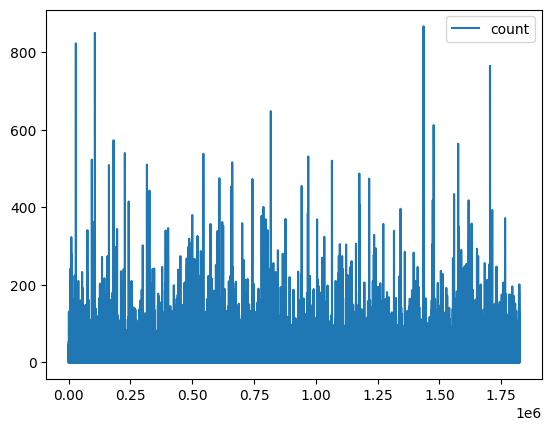

In [56]:
df_clicks_count[["count"]].plot()

In [57]:
%%time
df_carts_count = None
for f in train_files:
    df_tmp = read_parquet(f)
    df_tmp = df_tmp[df_tmp["type"]==TYPE_MAP["carts"]].groupby("aid").agg("count").reset_index()
    df_tmp = df_tmp[["aid", "session"]].rename({"session": "count"}, axis=1)
    if df_carts_count is None:
        df_carts_count = df_tmp
    else:
        df_carts_count = pd.concat([df_carts_count, df_tmp])
        df_carts_count = df_carts_count.groupby("aid").agg("sum").reset_index()
#     break
df_carts_count = df_carts_count.reset_index(drop=True)

CPU times: user 20.2 s, sys: 3.03 s, total: 23.3 s
Wall time: 18.7 s


In [63]:
df_carts_count["count"].unique().shape

(61,)

In [66]:
# df_carts_count["count"] = df_carts_count["count"]//100
df_carts_count.to_pickle(os.path.join(DATASET_PATH, "feature/carts_count.pkl"))

In [67]:
%%time
df_orders_count = None
for f in train_files:
    df_tmp = read_parquet(f)
    df_tmp = df_tmp[df_tmp["type"]==TYPE_MAP["orders"]].groupby("aid").agg("count").reset_index()
    df_tmp = df_tmp[["aid", "session"]].rename({"session": "count"}, axis=1)
    if df_orders_count is None:
        df_orders_count = df_tmp
    else:
        df_orders_count = pd.concat([df_orders_count, df_tmp])
        df_orders_count = df_orders_count.groupby("aid").agg("sum").reset_index()
#     break
df_orders_count = df_orders_count.reset_index(drop=True)

CPU times: user 16.2 s, sys: 2.03 s, total: 18.3 s
Wall time: 13.8 s


In [72]:
df_orders_count["count"] = df_orders_count["count"]//10

In [74]:
df_orders_count.to_pickle(os.path.join(DATASET_PATH, "feature/orders_count.pkl"))

# User Feature

## carts次数

In [13]:
df_carts_count = None
for f in train_files:
    df_tmp = read_parquet(f)
    df_tmp = df_tmp[df_tmp["type"]==TYPE_MAP["carts"]].groupby("session").agg("count").reset_index()
    df_tmp = df_tmp[["session", "aid"]].rename({"aid": "count"}, axis=1)
    if df_carts_count is None:
        df_carts_count = df_tmp
    else:
        df_carts_count = pd.concat([df_carts_count, df_tmp])
#     break
df_carts_count = df_carts_count.reset_index(drop=True)
df_carts_count

,session,count
0,0,3
1,1,8
2,3,21
3,5,1
4,9,1
...,...,...
3089890,11098382,1
3089891,11098409,1
3089892,11098423,2
3089893,11098444,2


In [17]:
df_carts_count.to_pickle(os.path.join(DATASET_PATH, "feature/session_carts_count.pkl"))

## clicks 次数

In [18]:
df_carts_count = None
for f in train_files:
    df_tmp = read_parquet(f)
    df_tmp = df_tmp[df_tmp["type"]==TYPE_MAP["clicks"]].groupby("session").agg("count").reset_index()
    df_tmp = df_tmp[["session", "aid"]].rename({"aid": "count"}, axis=1)
    if df_carts_count is None:
        df_carts_count = df_tmp
    else:
        df_carts_count = pd.concat([df_carts_count, df_tmp])
#     break
df_carts_count = df_carts_count.reset_index(drop=True)
df_carts_count

,session,count
0,0,142
1,1,19
2,2,13
3,3,200
4,4,2
...,...,...
11096174,11098523,1
11096175,11098524,1
11096176,11098525,1
11096177,11098526,1


In [19]:
df_carts_count.to_pickle(os.path.join(DATASET_PATH, "feature/session_clicks_count.pkl"))

## orders 次数

In [20]:
df_carts_count = None
for f in train_files:
    df_tmp = read_parquet(f)
    df_tmp = df_tmp[df_tmp["type"]==TYPE_MAP["orders"]].groupby("session").agg("count").reset_index()
    df_tmp = df_tmp[["session", "aid"]].rename({"aid": "count"}, axis=1)
    if df_carts_count is None:
        df_carts_count = df_tmp
    else:
        df_carts_count = pd.concat([df_carts_count, df_tmp])
#     break
df_carts_count = df_carts_count.reset_index(drop=True)
df_carts_count

,session,count
0,0,2
1,3,5
2,4,1
3,11,2
4,12,1
...,...,...
1314402,11098168,1
1314403,11098185,3
1314404,11098290,2
1314405,11098316,1


In [21]:
df_carts_count.to_pickle(os.path.join(DATASET_PATH, "feature/session_orders_count.pkl"))

In [11]:
read_parquet(test_files[-1])

,session,aid,ts,type
0,12809725,1080975,1661703782,0
1,12809726,46950,1661703782,0
2,12809727,1203591,1661703783,0
3,12809727,1203591,1661703793,1
4,12809728,543478,1661703783,0
...,...,...,...,...
316324,12899774,33035,1661723968,0
316325,12899775,1743151,1661723970,0
316326,12899776,548599,1661723972,0
316327,12899777,384045,1661723976,0


In [5]:
df = pd.read_pickle("/home/search2/lichunyu/otto-recommender-system/data/input/otto-validation/test_candidates/candidate_comatrix_exploded_details.pkl")
df

,session,aid,ts,type
0,11098528,11830,1661119200,0
1,11098528,1732105,1661119200,3
2,11098528,588923,1661119200,3
3,11098528,876129,1661119200,3
4,11098528,884502,1661119200,3
...,...,...,...,...
182272660,12899778,314422,1661119200,3
182272661,12899778,357194,1661119200,3
182272662,12899778,362673,1661119200,3
182272663,12899778,377330,1661119200,3
